<h2><center>Генеративные сети</center></h2>

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа.

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [394]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [395]:
data['class'].value_counts()

g    12332
h     6688
Name: class, dtype: int64

In [49]:
data.dtypes

Length     float64
Width      float64
Size       float64
Conc       float64
Conc1      float64
Asym       float64
M3Long     float64
M3Trans    float64
Alpha      float64
Dist       float64
class       object
dtype: object

# Постановка задачи

Задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно научиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [396]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [51]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [52]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [53]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [54]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

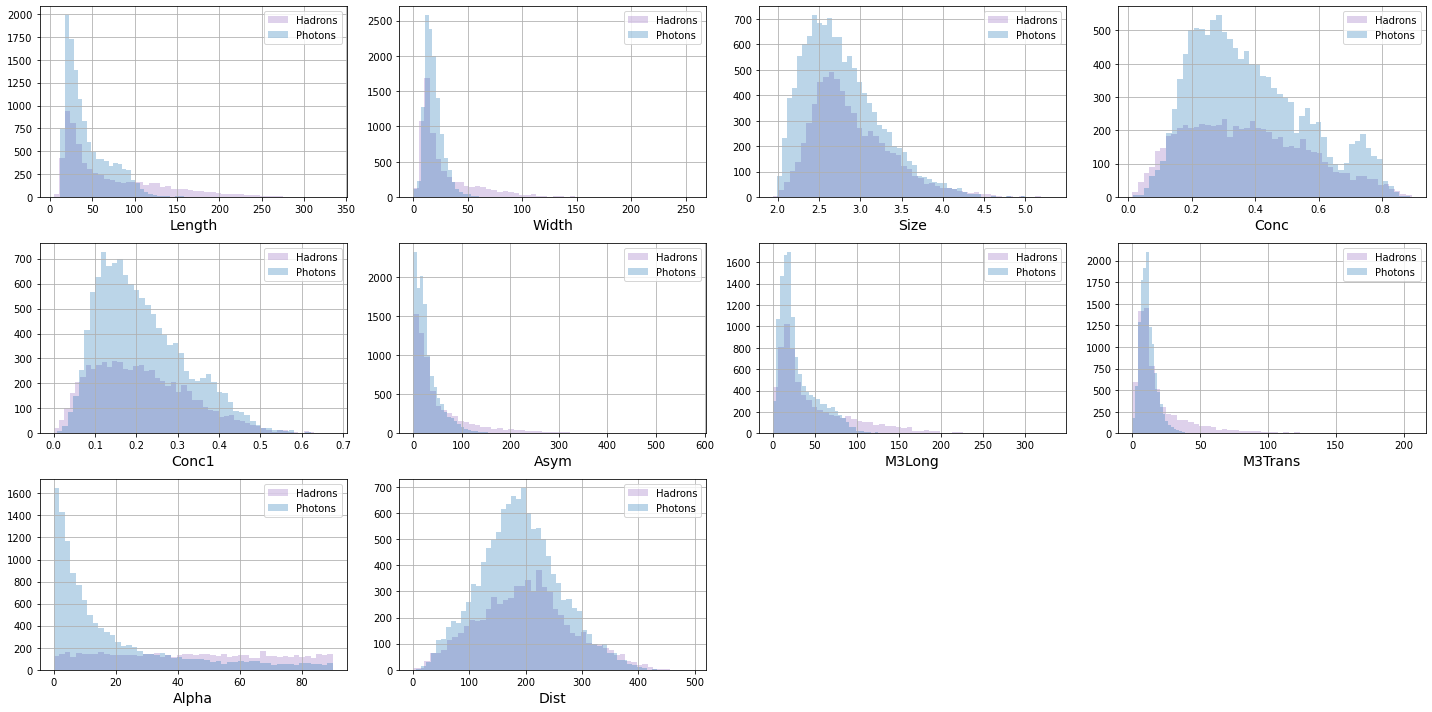

In [55]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [397]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

Проиллюстрируем распределение y внутри train и test выборки.

In [57]:
a = len(y_train[y_train == 0]), len(y_train[y_train == 1])

In [58]:
b = len(y_test[y_test == 0]), len(y_test[y_test == 1])

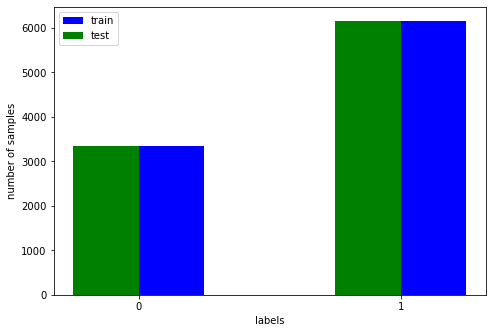

In [59]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(2)
ax.bar(X + 0.125, a, color = 'b', width = 0.25)
ax.bar(X - 0.125, b, color = 'g', width = 0.25)
plt.legend(['train', 'test'])
plt.ylabel('number of samples')
plt.xlabel('labels')
plt.xticks([0, 1])
plt.show()

In [60]:
# Равномернее некуда

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируем входные данные `X_train` и `X_test`

In [398]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=0)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

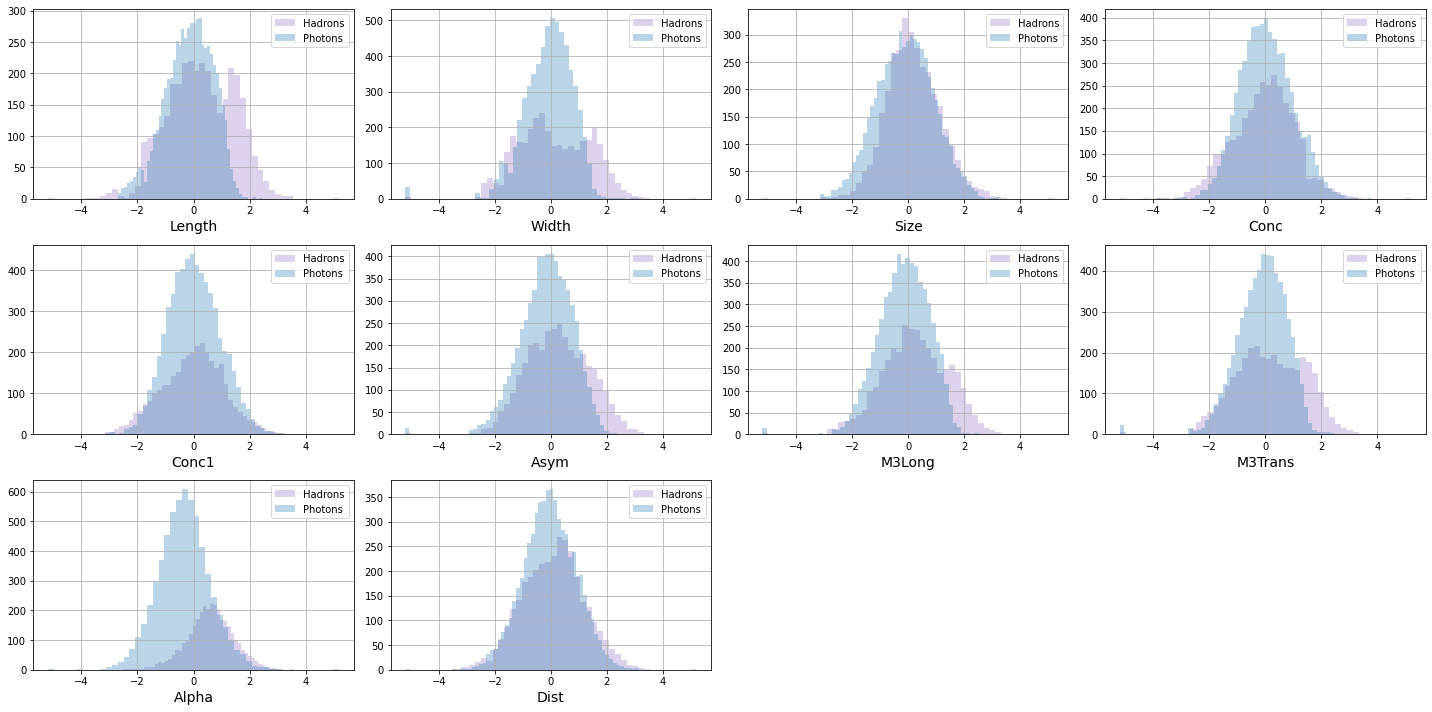

In [63]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

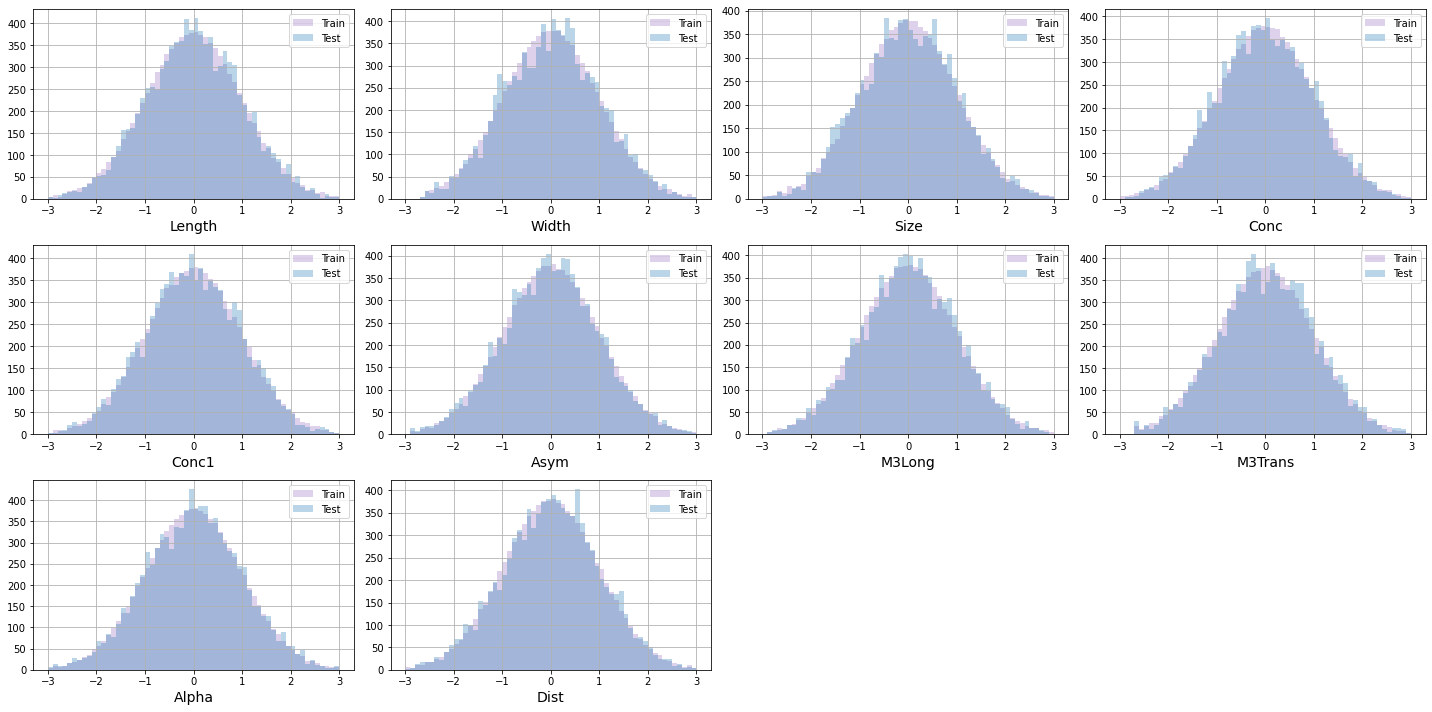

In [64]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

In [ ]:
# Все вышло, на картинках, как и надо, нормальные распределения

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
DEVICE

device(type='cpu')

Реализуем нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [114]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, n_outputs)
        )
        
    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

Реализуем функцию для генерации новый объектов $X$ по вектору условий $y$.

In [200]:
def generate(generator, y, latent_dim):
    noise = torch.normal(0, 1, (len(y), latent_dim))
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    X_fake = generator.forward(noise, y)
    return X_fake.detach().numpy() # numpy

Реализуем нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [250]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        zy = torch.cat((x, y), dim=1)
        return self.net(zy)

In [ ]:
# Мы хотим один выход - как бы скор объекта. Чтобы было заранее известно в каком диапазоне ожидать выход, мы используем 
# сигмоиду. Также мы с ее помощью можем интерпретировать выход как уверенность в предсказании: если получаем число, близкое к
# единице, то модель довольно таки уверена, что ей на вход дали реальный объект, если получаем число, близкое к нулю, то 
# модель считает, что перед ней фейк. В случае скора ~ 0.5 дискриминатор не понял что перед ним - фейк или настоящие данные.
# Софтмакс здесь, очевидно, не подходит, так как тогда на выходе всегда единичка.

Реализуем функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [208]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    data_real = np.concatenate((X_real, y_real), axis = 1)
    data_fake = np.concatenate((X_fake, y_fake), axis = 1)
    
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    data_real, np.ones(len(data_real)).reshape((-1,1)), test_size=0.25, shuffle = True, random_state = 11
    )
    X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(
    data_fake, np.zeros(len(data_fake)).reshape((-1,1)), test_size=0.25, shuffle = True, random_state = 11
    )
    
    X_train = np.concatenate((X_train_real, X_train_fake), axis = 0)
    X_test = np.concatenate((X_test_real, X_test_fake), axis = 0)
    y_train = np.concatenate((y_train_real, y_train_fake), axis = 0)
    y_test = np.concatenate((y_test_real, y_test_fake), axis = 0)
    
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, clf.predict(X_test))
    
    boost = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, boost.predict(X_test))
    return lin_reg_score, boosting_score

Очевидно, нас бы удовлетворило accuracy = 0.5, так как мы хотим, чтобы дискриминатор не мог отличить реальные данные от фейковых. То есть если accuracy > 0.5, то значит дискриминатор хоть немного умеет различать, то есть мы нагенерировали данные, не совсем похожие на реальные. Если дискриминатор имеет accuracy < 0.5, то все равно не очень. Это означет, что он перепутал классы, но он все равно нашел зависмости (то есть как можно разделить один кластер от другого), что тоже для нас нехорошо.

## Реализуем класс для обучения генеративной модели

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [189]:
from typing_extensions import Literal
from IPython.display import clear_output

In [201]:
# Реализуем вышеописанный лосс
def gan_loss(real_objects_scores: torch.Tensor, 
            generated_objects_scores: torch.Tensor, 
            by: Literal["generator", "discriminator"]) -> torch.Tensor:
    if by == "generator":
        return generated_objects_scores.mean()
    elif by == "discriminator":
        return real_objects_scores.mean() - generated_objects_scores.mean()

In [253]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.gen_loss_trace = []
        self.discr_loss_trace = []
        self.loss_history = []
        self.clf_score_history = []
        self.boost_score_history = []

        iter_i = 0
        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # генерируем новые объекты
                noise = torch.normal(0, 1, (len(real_batch), self.latent_dim))
                fake_batch = self.generator(noise, cond_batch)

                # считаем скоры
                num_objects = len(real_batch)
                real_objects_scores = self.discriminator(real_batch, cond_batch)
                gen_objects_scores = self.discriminator(fake_batch, cond_batch)
                
                if iter_i % (self.n_critic + 1) == 0:
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = gan_loss(real_objects_scores, gen_objects_scores, "generator")
                    gen_loss.backward()
                    self.opt_gen.step()
                    self.gen_loss_trace.append((iter_i, gen_loss.item()))
                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()
                    discr_loss = gan_loss(real_objects_scores, gen_objects_scores, "discriminator")
                    discr_loss.backward()
                    self.opt_disc.step()
                    self.discr_loss_trace.append((iter_i, discr_loss.item()))
                    # Ограничиваем веса
                    for p in self.discriminator.named_parameters():
                        p[1].data.clamp_(-0.01, 0.01)

                iter_i += 1
                
                # раз в verbose_num_iters визуализируем наши лоссы и семплы
                verbose_num_iters = 100
                if iter_i % verbose_num_iters == 0:
                    clear_output(wait=True)
                    plt.figure(figsize=(10, 5))

                    plt.subplot(1, 3, 1)
                    plt.xlabel("Iteration")
                    plt.ylabel("Generator loss")
                    plt.plot([p[0] for p in self.gen_loss_trace], [p[1] for p in self.gen_loss_trace])

                    plt.subplot(1, 3, 2)
                    plt.xlabel("Iteration")
                    plt.ylabel("Discriminator loss")
                    plt.plot(
                        [p[0] for p in self.discr_loss_trace],
                        [p[1] for p in self.discr_loss_trace],
                        color="orange",
                    )

                    plt.show()

            # calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - \
                        torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создаем выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустим работу фукнции other_agent_score

            Z_noise = torch.normal(0, 1, (len(X_real[:1000]), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond[:1000])
            clf_loss, boost_loss = other_agent_score(X_real[:1000].detach().numpy(), y_cond[:1000].detach().numpy(), 
                              X_fake.detach().numpy(), y_cond[:1000].detach().numpy())
            self.clf_score_history.append(clf_loss)
            self.boost_score_history.append(boost_loss)
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

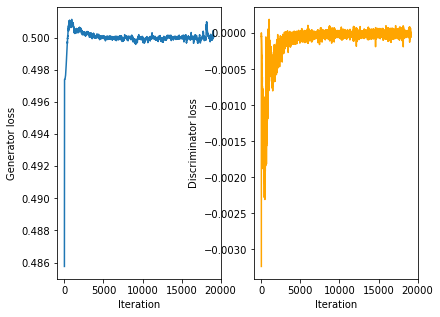

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 2min 5s


In [254]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Generator loss нам считает среднее generated_objects_scores, и если дискриминатор хорошо разделяет объекты, то этот лосс близок к нулю/единице, а мы тут видим, что лосс близок к 0.5, что хорошо, так как это означает, что дискриминатор не может отличить сгенерированные объекты от реальных.
Discriminator loss же должен стремиться к нулю, так как мы хотим, чтобы скоры сгенерированных объектов были такими же, как у реальных. Видим, что ровно это и происходит

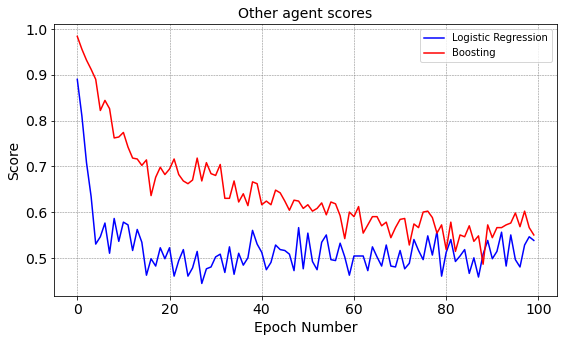

In [255]:
plt.figure(figsize=(9, 5))
plt.plot(fitter.clf_score_history, color = 'b')
plt.plot(fitter.boost_score_history, color = 'r')
plt.legend(['Logistic Regression', 'Boosting'])
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Score", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Other agent scores", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

In [ ]:
# Уже писал, что чем ближе к 0.5, тем лучше. Видим, что стремимся именно к этому числу (бустинг помедленнее, так как
# это все-таки более сильная модель)

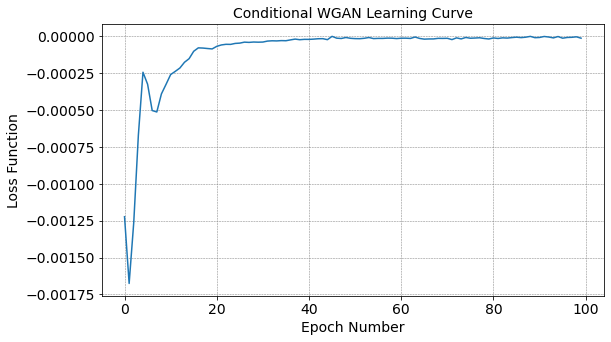

In [256]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [257]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [262]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)

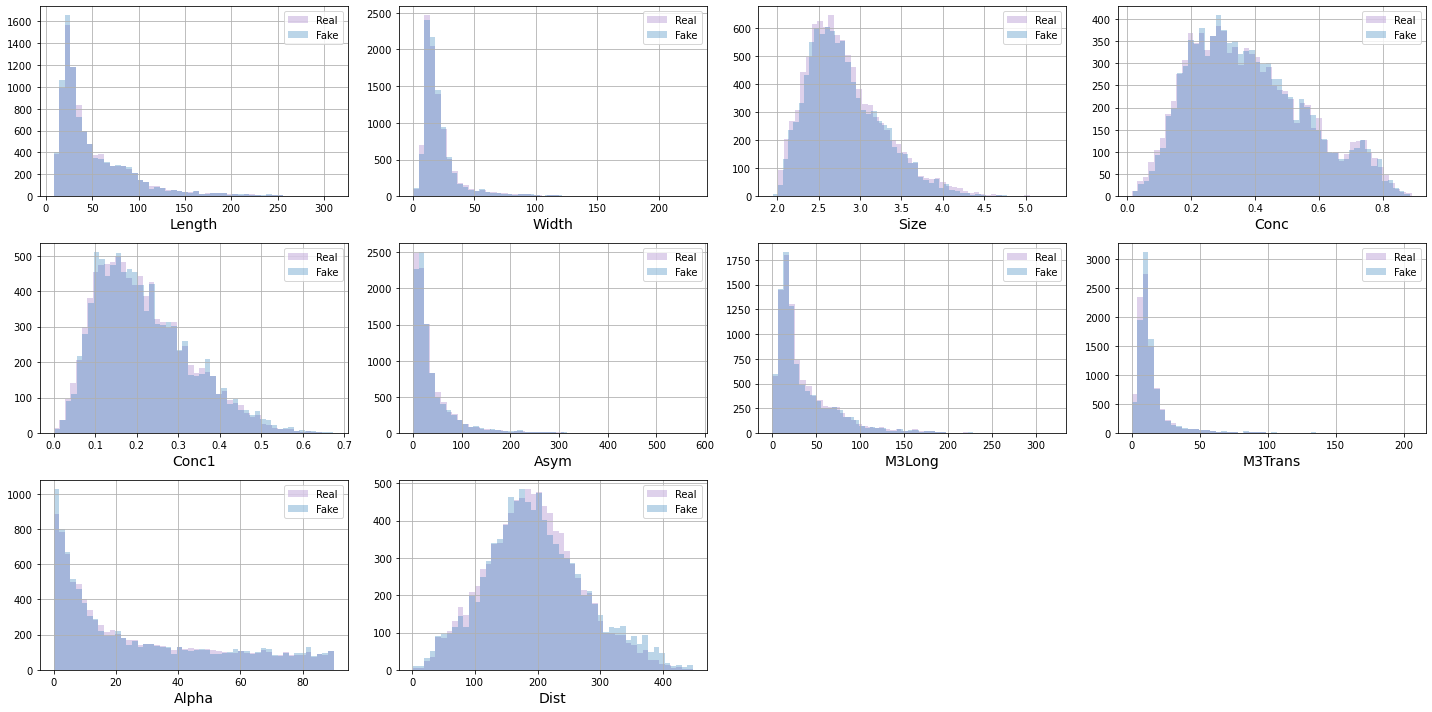

In [263]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [264]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)

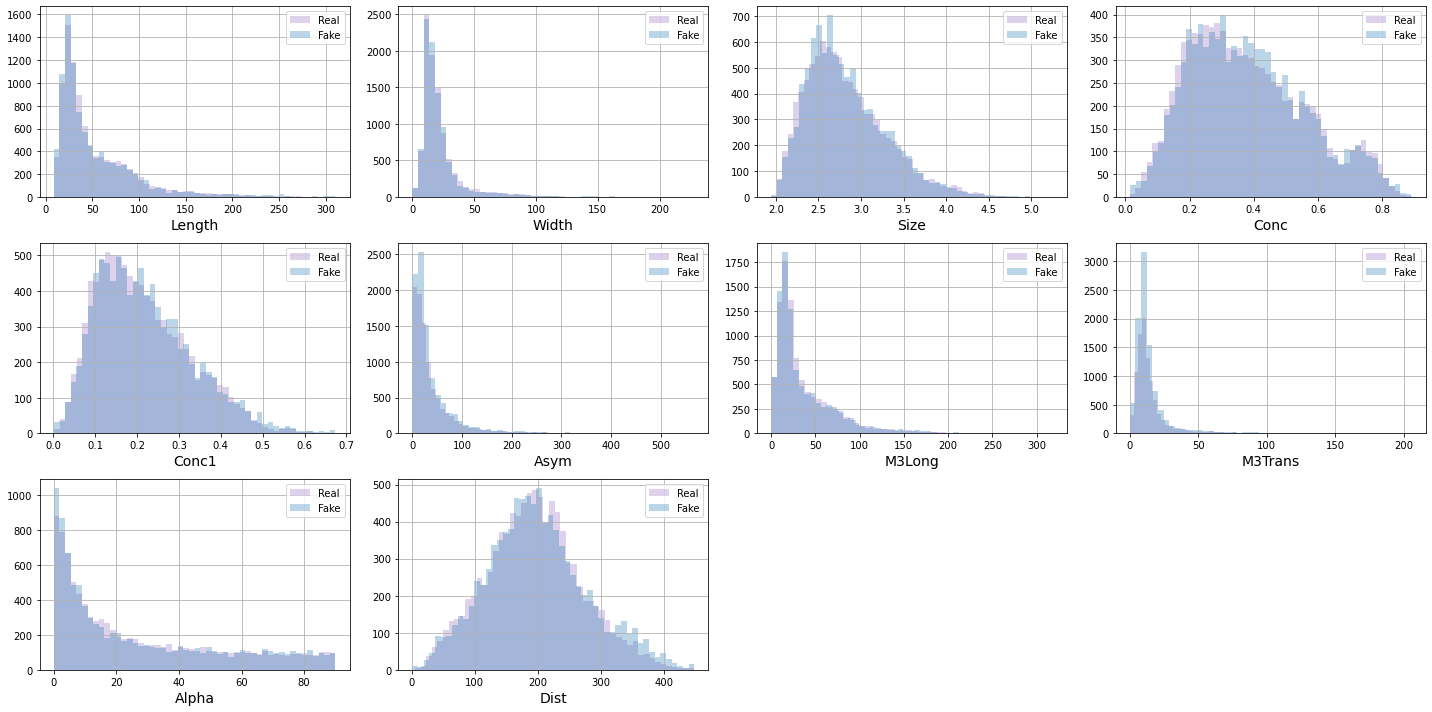

In [265]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [266]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [267]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [268]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6866768999591996


In [ ]:
# Не самый плохой результат

Опять же, идеальный ROC AUC в нашем случае - 0.5. Это бы обозначало, что фейковые и реальные данные очень похожи и их невозможно хорошо разделить (как на картиночке сверху). Одномерые проекции наших десятимерных объектов визуально очень похожи по распределению, но это не значит, что в десятимерном пространстве все также хорошо. Видимо комбинации значений признаков объектов не идеально похожи на реальные, поэтому классификатор выше как-то может различить некоторые объекты, однако определнный результат есть. Возможно, он не подойдет для серьезных целей, но как минимум база есть, т.е. есть возможность улучшить результаты (попробовав другой лосс, усложнив архитектуры генератора и дискриминатора, уменьшив шаг в гадиентном спуске и тд)

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

Реализуем фукнцию для зашумления данных

In [414]:
def corrupt(x, amount):
    noise = torch.randn(x.shape[0],x.shape[1])
    return x*(1-amount) + noise*amount

In [415]:
corrupt(torch.tensor([[1,2,3],[2,3,4]]), 0.5)

tensor([[-0.2398,  1.4919,  0.9694],
        [-0.0724,  1.4581,  1.3631]])

In [416]:
corrupt(torch.tensor([[1,2,3],[2,3,4]]), torch.tensor([0.5, 0.6]).reshape(-1,1))

tensor([[0.6101, 0.1802, 1.1202],
        [2.3056, 1.6761, 2.3112]])

## Добавим sсheduler, он пригодится вам при обучении модели

In [271]:
!pip install -q diffusers wandb

In [272]:
from diffusers import DDPMScheduler

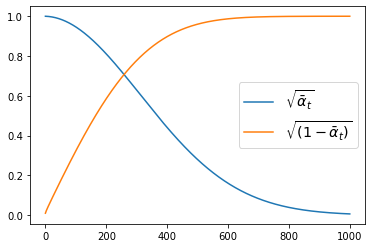

In [274]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")
plt.show()

Реализуем нейронную сеть. 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [340]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_inputs, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, n_outputs)
        )

    def forward(self, z, y, t): # t для учитывания timesteps/amount
        zy = torch.cat((z, y), dim=1)
        zyt = torch.cat((zy, t), dim=1)
        return self.net(zyt)

In [ ]:
# По идее, качество будет измерять по MSE. На вход функции потерь подается шум и
# результат работы нейронной сети на зашумленных данных (то есть модель обучается предсказывать шум). Это если пользоваться
# шедулером. У меня не получилось с ним получить хориший результат, поэтому немного переписал fitter и уже использовал
# функцию corrupt. Соответсвенно, там обучение по MSE, но на вход функции потерь подается pred и clean_data, то есть модель 
# учится не предсказывать шум, а сразу из шума пытается сделать нужные нам данные

Напишим функцию для генерации нового объекта с помощью обученной модели.

In [299]:
from tqdm import tqdm

In [345]:
def generate_with_diffusion(model, y, latent_dim, noise_scheduler):
    X_fake = torch.normal(0, 1, (len(y), latent_dim))
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    # Sampling loop
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
        
        # Get model pred
        with torch.no_grad():
            residual = model(X_fake, y, torch.tensor([t] * len(y)).reshape(-1,1)) 

        # Update sample with step
        X_fake = noise_scheduler.step(residual, t, X_fake).prev_sample
    return X_fake.detach().numpy()  # numpy

Напишим класс обучения диффузионной модели и обучим модель

In [363]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        noise_scheduler,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.scheduler = noise_scheduler
        
        self.loss_fn = nn.MSELoss()
        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        self.clf_score_history = []
        self.boost_score_history = []
        self.clf_score_history = []
        self.boost_score_history = []

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # prepare the corrupted version
                noise = torch.normal(0, 1, (real_batch.shape[0], real_batch.shape[1]))
                timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long().to(DEVICE)
                noisy_x = self.scheduler.add_noise(real_batch, noise, timesteps)

                # Get the model prediction
                pred = self.model(noisy_x, cond_batch, timesteps.reshape(-1,1)) # Note that we pass in the labels y

                # Calculate the loss
                loss = self.loss_fn(pred, noise) # How close is the output to the noise

                # Backprop and update the params:
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch)
            
            # Создаем выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запускаем работу фукнции other_agent_score
            
            X_fake = generate_with_diffusion(self.model, y_cond[:1000], self.latent_dim, self.scheduler)
            clf_loss, boost_loss = other_agent_score(X_real[:1000].detach().numpy(), y_cond[:1000].detach().numpy(), 
                              X_fake, y_cond[:1000].detach().numpy())
            self.clf_score_history.append(clf_loss)
            self.boost_score_history.append(boost_loss)
            
        # Turn off training
        self.model.train(False)

In [352]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [313]:
import warnings

warnings.filterwarnings('ignore')

In [349]:
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

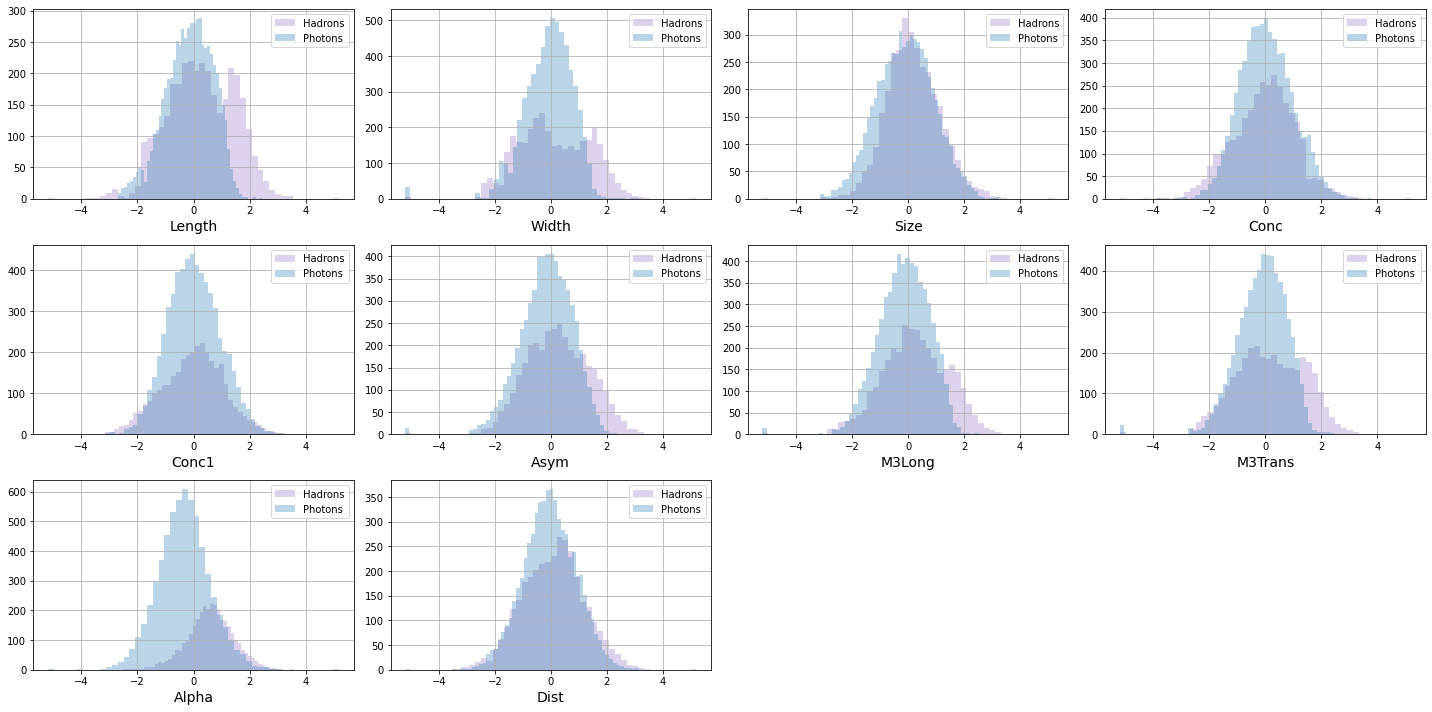

In [361]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

In [364]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1] + 1, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    noise_scheduler,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

1000it [00:01, 560.32it/s]
1000it [00:01, 601.21it/s]
1000it [00:01, 546.29it/s]
1000it [00:01, 545.99it/s]
1000it [00:01, 571.91it/s]
1000it [00:01, 567.36it/s]
1000it [00:01, 571.26it/s]
1000it [00:01, 541.85it/s]
1000it [00:01, 531.96it/s]
1000it [00:01, 540.54it/s]
1000it [00:01, 550.61it/s]
1000it [00:01, 583.77it/s]
1000it [00:01, 579.38it/s]
1000it [00:01, 563.56it/s]
1000it [00:01, 521.33it/s]
1000it [00:01, 531.07it/s]
1000it [00:01, 561.80it/s]
1000it [00:01, 575.37it/s]
1000it [00:01, 544.35it/s]
1000it [00:01, 530.64it/s]
1000it [00:01, 508.87it/s]
1000it [00:02, 493.99it/s]
1000it [00:01, 548.62it/s]
1000it [00:01, 550.05it/s]
1000it [00:01, 549.45it/s]
1000it [00:01, 556.48it/s]
1000it [00:01, 553.71it/s]
1000it [00:01, 566.53it/s]
1000it [00:01, 539.67it/s]
1000it [00:01, 567.69it/s]
1000it [00:01, 544.81it/s]
1000it [00:01, 534.32it/s]
1000it [00:01, 558.35it/s]
1000it [00:01, 567.23it/s]
1000it [00:01, 564.47it/s]
1000it [00:01, 561.61it/s]
1000it [00:01, 540.54it/s]
1

Wall time: 4min 19s


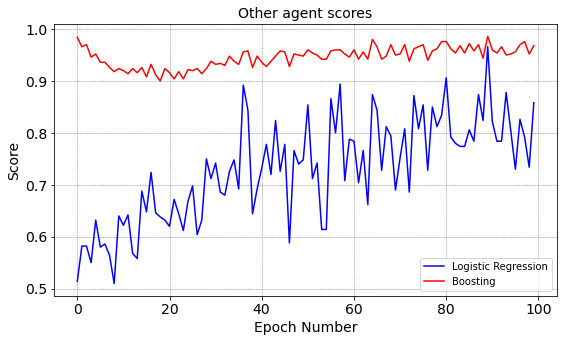

In [365]:
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.clf_score_history, color = 'b')
plt.plot(diffusionFitter.boost_score_history, color = 'r')
plt.legend(['Logistic Regression', 'Boosting'])
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Score", size=14)
plt.xticks(size=14)
plt.yticks(size=14)  
plt.title("Other agent scores", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

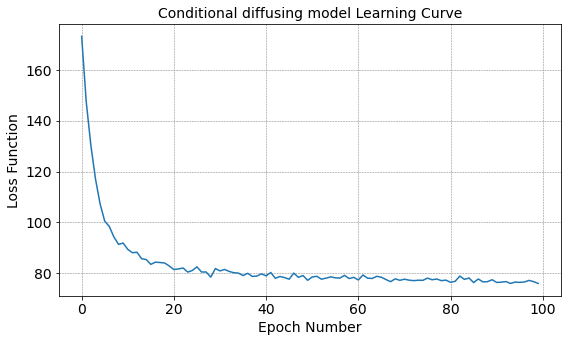

In [366]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Видим, что вышло как-то странно. Модель обучается, лосс падает, но при это other agent scores ведут себя не так, как нам бы хотелось. Это первая попытка, оставляю ее для истории, так как здесь реализовано обучение с шедулером, как и было на семинаре (собственно, сделал очень похоже, не знаю в чем тут проблема может быть). Вторая попытка будет ниже, там все более менее вышло

По аналогии с прошлым экспериментом с GAN моделью сгенерируем выборку фейковых объектов равную размеру тестовой выборки и обучим градиентный бустинг.

In [387]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [374]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler)
X_fake_train = qt.inverse_transform(X_fake_train)

1000it [00:12, 77.08it/s]


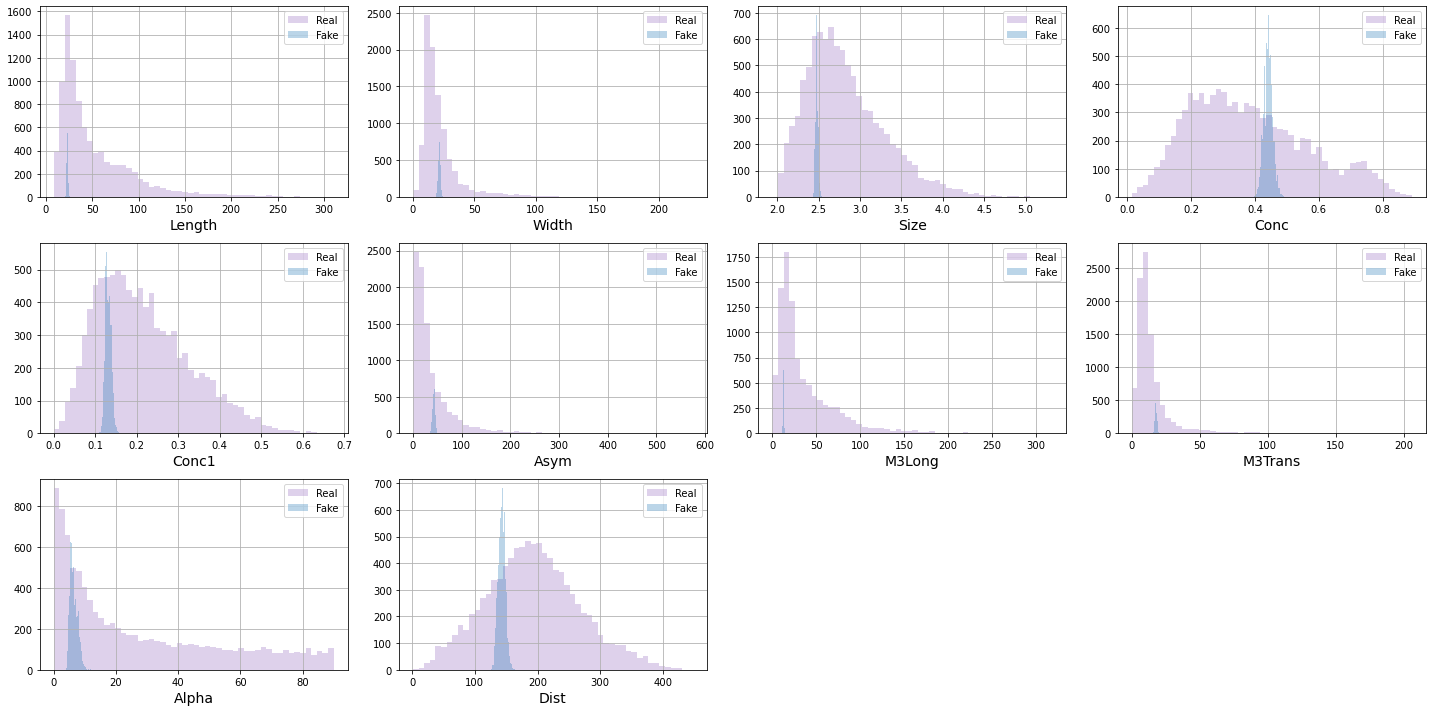

In [388]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [383]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)
X_fake_test = qt.inverse_transform(X_fake_test)

1000it [00:12, 76.99it/s]


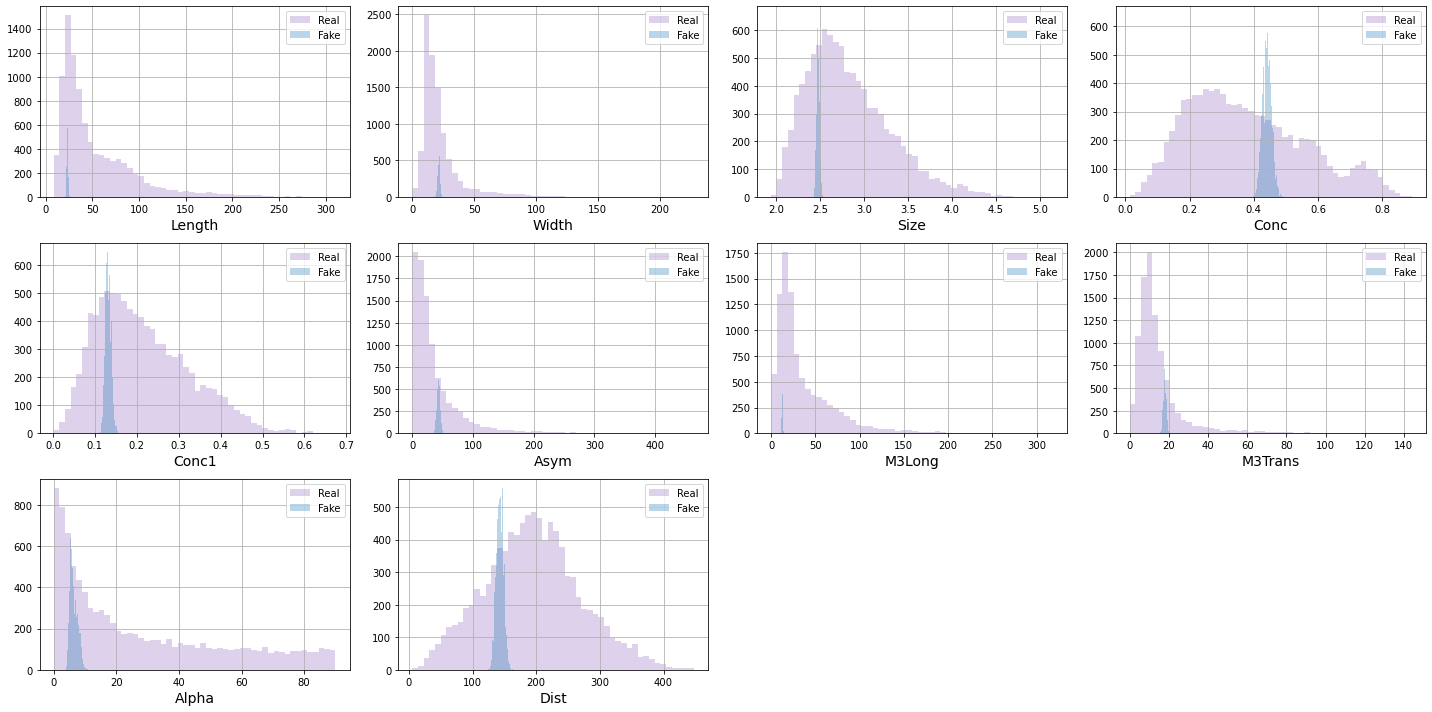

In [384]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [ ]:
# Даже визуального сходства нет... Почему-то сгенерированные объекты распределены почти по нормальному закону. Это 
# настораживает, но причину этого не смог отследить. Вроде обратное преобразование применил...

In [376]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [377]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [378]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  1.0


In [ ]:
# C шедулером так странно выходит. Попробуем с функцией corrupt поиграться. Тут уже будем учить модель
# очищать данные от шума, то есть в лосс будет подаваться pred и clean_data

In [419]:
class DiffusionFitter1(object):
    def __init__(
        self,
        model,
        noise_scheduler,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.scheduler = noise_scheduler
        
        self.loss_fn = nn.MSELoss()
        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        self.clf_score_history = []
        self.boost_score_history = []
        self.clf_score_history = []
        self.boost_score_history = []

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # prepare the corrupted version
                noise_amount = torch.rand(real_batch.shape[0]).to(DEVICE) # Pick random noise amounts
                noisy_x = corrupt(real_batch, noise_amount.reshape(-1,1)) # Create our noisy x

                # Get the model prediction
                pred = self.model(noisy_x, cond_batch, noise_amount.reshape(-1,1)) # Note that we pass in the labels y

                # Calculate the loss
                loss = self.loss_fn(pred, real_batch) # How close is the output to clean_data

                # Backprop and update the params:
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch)
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            # Samples
            n_steps = 40
            X_fake = torch.normal(0, 1, (1000, self.latent_dim))
            for i in range(n_steps):
                noise_amount = torch.ones((X_fake.shape[0], )).to(DEVICE) * (1-(i/n_steps)) # Starting high going low
                with torch.no_grad():
                    pred = self.model(X_fake, y_cond[:1000], noise_amount.reshape(-1,1))
                mix_factor = 1/(n_steps - i)
                X_fake = X_fake*(1-mix_factor) + pred*mix_factor
            
            clf_loss, boost_loss = other_agent_score(X_real[:1000].detach().numpy(), y_cond[:1000].detach().numpy(), 
                              X_fake, y_cond[:1000].detach().numpy())
            self.clf_score_history.append(clf_loss)
            self.boost_score_history.append(boost_loss)
            
        # Turn off training
        self.model.train(False)

In [392]:
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

In [420]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1] + 1, n_outputs=X_train.shape[1])

diffusionFitter1 = DiffusionFitter1(
    model,
    noise_scheduler,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter1.fit(X_train, y_train)

Wall time: 1min 16s


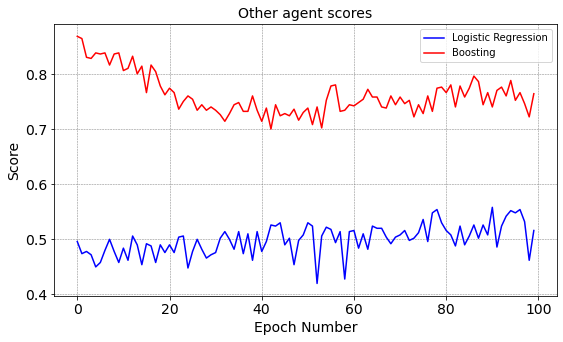

In [423]:
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter1.clf_score_history, color = 'b')
plt.plot(diffusionFitter1.boost_score_history, color = 'r')
plt.legend(['Logistic Regression', 'Boosting'])
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Score", size=14)
plt.xticks(size=14)
plt.yticks(size=14)  
plt.title("Other agent scores", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

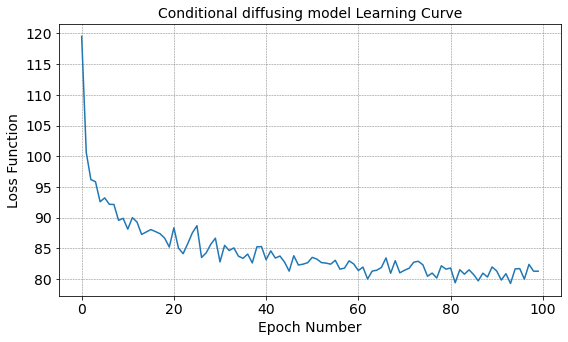

In [424]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter1.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

In [ ]:
# Так, ну такие кривые мне нравятся куда больше. Смотрим на roc auc

In [425]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [430]:
n_steps = 40
X_fake_train = torch.normal(0, 1, (X_train.shape[0], latent_dim))
for i in range(n_steps):
    noise_amount = torch.ones((X_fake_train.shape[0], )).to(DEVICE) * (1-(i/n_steps)) # Starting high going low
    with torch.no_grad():
        y_cond = torch.tensor(y_train, dtype=torch.float, device=DEVICE)
        pred = model(X_fake_train, y_cond, noise_amount.reshape(-1,1))
    mix_factor = 1/(n_steps - i)
    X_fake_train = X_fake_train*(1-mix_factor) + pred*mix_factor
X_fake_train = qt.inverse_transform(X_fake_train)

In [431]:
n_steps = 40
X_fake_test = torch.normal(0, 1, (X_test.shape[0], latent_dim))
for i in range(n_steps):
    noise_amount = torch.ones((X_fake_test.shape[0], )).to(DEVICE) * (1-(i/n_steps)) # Starting high going low
    with torch.no_grad():
        y_cond = torch.tensor(y_test, dtype=torch.float, device=DEVICE)
        pred = model(X_fake_test, y_cond, noise_amount.reshape(-1,1))
    mix_factor = 1/(n_steps - i)
    X_fake_test = X_fake_test*(1-mix_factor) + pred*mix_factor
X_fake_test = qt.inverse_transform(X_fake_test)

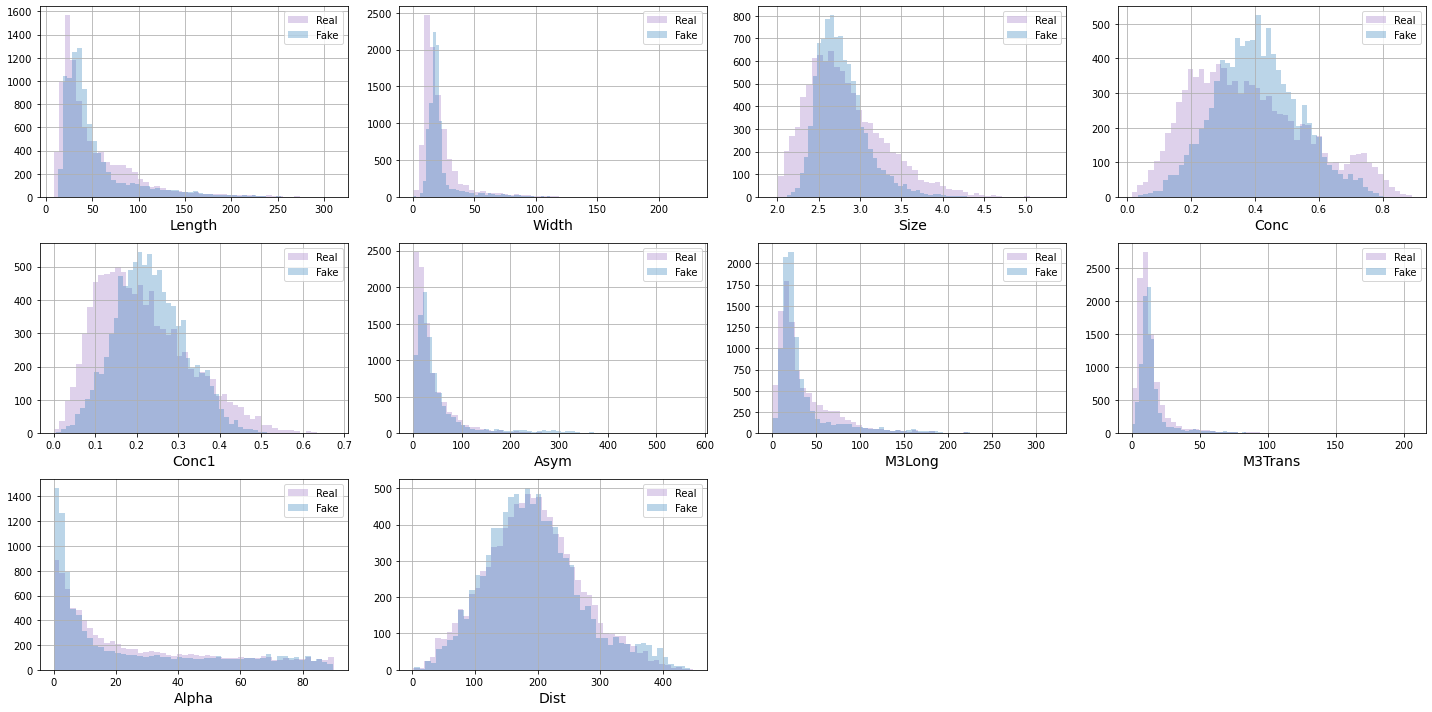

In [432]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

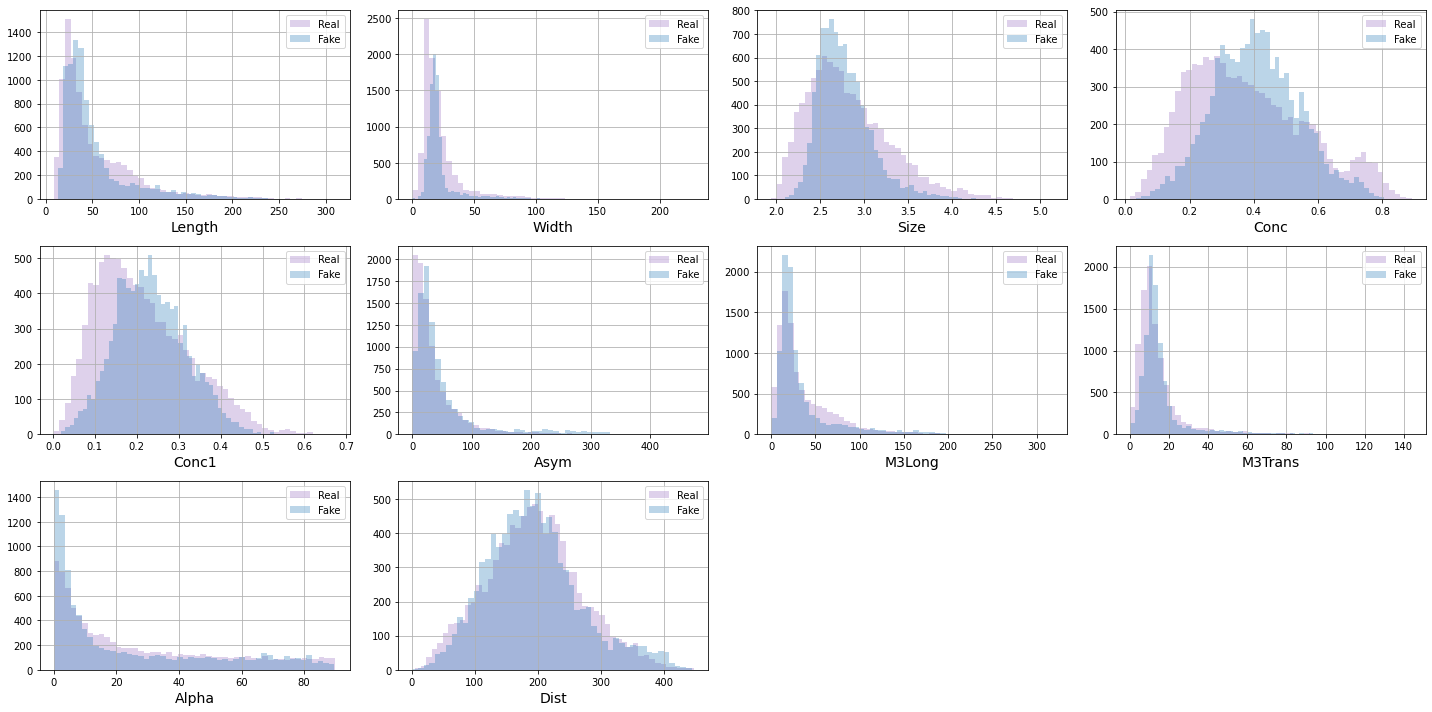

In [433]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [ ]:
# О, теперь даже видим визуальное сходство, что неплохо

In [434]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.9227756327115959


Что ж, тут хоть что-то обучилось, хоть и качество нас совсем не утроило. У GAN'а результат куда солиднее вышел, но, возможно, у диффузионной модели больше потенциала, если покрутить архитектуру/гиперпараметры